In [62]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.style.use('seaborn-dark-palette')
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "sans-serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)
import drone_env
from drone_env import *
from tqdm import tqdm, trange
from IPython import display
from SAC_agents import RandomAgent, CriticNN
from collections import namedtuple, deque
from SAC_agents import *
import torch
import torch.nn as nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Checking the environment

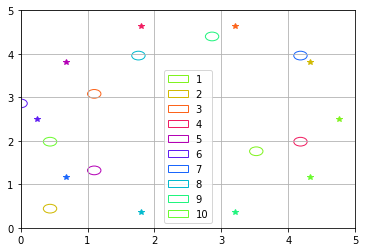

In [2]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)
# print(env)
env.show()

## Simple gradient control. $ u_i = -\nabla _x c_i $

$$ c_i = q|| x_i-x_B ||^2 +  b \sum_{j \in N_i} \log (\frac{\hat{d}_i}{|| x_i-x_j || - r_i -r_j})$$

$$ \nabla _x c_i = 2q (x_i-x_B) - b \sum_{j \in N_i} \frac{1}{|| x_i-x_j || -r_i -r_j} \cdot \frac{x_i-x_j}{|| x_i -x_j ||} $$


100%|██████████| 500/500 [00:02<00:00, 189.80it/s]


Total collisions = 0


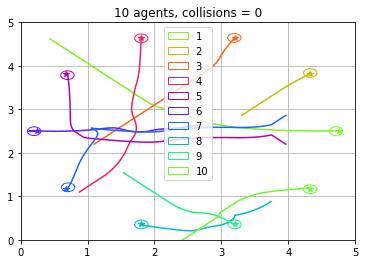

In [3]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)


T = 5
times = np.arange(0,T,step=drone_env.dt) + drone_env.dt

total_collisions = 0
reward_history = np.zeros([len(times), env.n_agents])

trajectory = [env.state.copy()]

for iter,t in enumerate(tqdm(times)):
## Simple gradient controller u_i = -grad_i, assuming Nj = V
    state = env.state
    
    # calculate actions based on current state
    actions = drone_env.gradient_control(state,env)

    # Update environment one time step with the actions
    new_state, new_z, rewards, n_collisions, finished = env.step(actions)

    total_collisions += n_collisions
    reward_history[iter,:] = np.mean(rewards)
    trajectory.append(new_state.copy())

# print(env.trajectory[-1])
print(f"Total collisions = {total_collisions}")
env.plot(trajectory)

In [57]:
# env.animate(frame_time = 0.05, frames = 30)


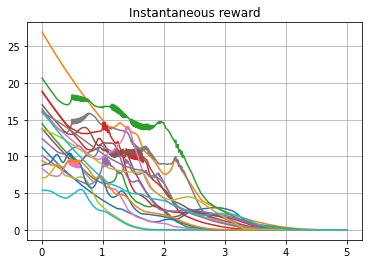

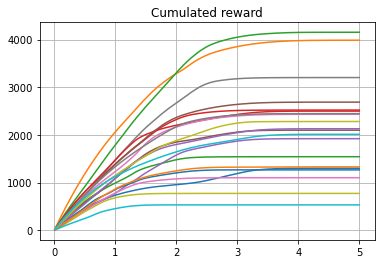

In [58]:
plt.plot(times,-reward_history);
plt.grid(True);
plt.title("Instantaneous reward")
plt.show()

cumulated_reward = np.cumsum(reward_history,0)

plt.plot(times,-cumulated_reward);
plt.grid(True);
plt.title("Cumulated reward")  
plt.show()

### Checking z state 

In [116]:

### Set up parameters ###
n_agents = 3
deltas = np.ones(n_agents)*2
env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 1

T = 5 # Simulate for T seconds (default dt = drone_env.dt = 0.01s) t_iter t=500

### 

# Initialize variables
total_collisions_list = deque()
total_reward_list = deque()
mean_critic_error = np.zeros([env.n_agents, N_Episodes])
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

times = np.arange(0, T, step=drone_env.dt) + drone_env.dt
EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)


agents = TrainedAgent(file_name="Q_test_1000eps-critics.pth", n_agents=env.n_agents)
print("### Running Trained agent (no learning)")
print(f"Episodes = {N_Episodes}, Time iterations = {len(times)} (T = {T}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}")

for episode in EPISODES:

    # reward_history = np.zeros([len(times), env.n_agents])
    trajectory = [env.state.copy()]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)
    # SIMULATION OVER T
    for t_iter, time in enumerate(times):
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states

        # calculate actions based on current state
        actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        # reward_history[t_iter,:] = reward
        trajectory.append(new_state.copy())

    # END OF EPISODE
    # Append episode reward
    total_reward_list.append(total_episode_reward)
    total_collisions_list.append(total_episode_collisions)

    # Test Critic values
    Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    critic_error = [np.mean(np.power(Q_simulated[i]-Q_approx[i],2)) for i in range(env.n_agents)]

    mean_critic_error[:,episode] = np.array([critic_error])

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_list, 50)[-1]
    average_collisions = running_average(total_collisions_list, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter+1} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter+1}")

    # Plot current trajectory

    if episode >= N_Episodes-0:
        env.plot(trajectory)

        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_simulated[i], label=f"i={i}, simulated Q", color = agent_color)
            plt.plot(times,Q_approx[i],"--" , label=f"i={i}, approx Q", color = tuple(0.9*x for x in agent_color))
        plt.legend()
        plt.show()


Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[4.4  4.18 0.   0.   0.1 ]
 [0.44 2.2  0.   0.   0.1 ]
 [0.66 1.54 0.   0.   0.1 ]]
safety distance for each agent:
 [3.69 3.69 3.69]
Deltas disk radius for each agent: 
 [2. 2. 2.]
Obstacles [x, y, r]:
 []



Episode:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded Critic, n_agents = 10, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=8, out_features=400, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=400, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
### Running Trained agent (no learning)
Episodes = 1, Time iterations = 500 (T = 5s, dt = 0.01s)
N of agents = 3


Episode 0 - Reward/Collisions/Steps: -265.6/0/500 - Average: 0.0/0.00/500: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


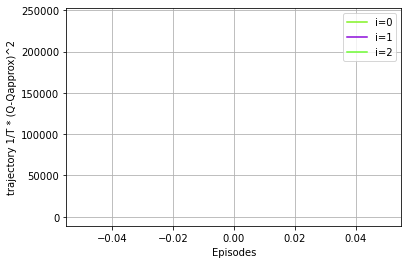

In [117]:
# plot_rewards(total_reward_list,total_collisions_list, n_ep_running_average=5)

plt.figure()
for i in range(env.n_agents):
        agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
        plt.plot(range(N_Episodes),mean_critic_error[i,:], label=f"i={i}", color = agent_color)
plt.xlabel("Episodes")
plt.ylabel("trajectory 1/T * (Q-Qapprox)^2")
plt.legend()
plt.grid()
plt.show()

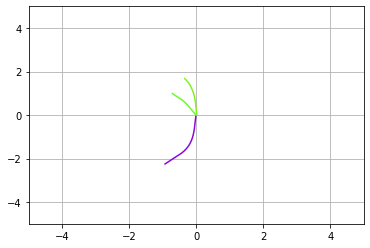

In [118]:

plt.figure()
plt.grid()
plt.xlim(-5,5)
plt.ylim(-5,5)

for i in range (env.n_agents):
    z_states_agent = [exp.z_state for exp in buffers.buffers[i]]

    zi = np.zeros([len(z_states_agent), 2])
    zj1 = np.zeros([len(z_states_agent), 2])
    zj2 = np.zeros([len(z_states_agent), 2])

    for t, z_sate in enumerate(z_states_agent):
        zi[t,:]  = z_sate[0:2]
        zj1[t,:] = z_sate[2:4]
        zj2[t,:] = z_sate[4:6]

    agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
    plt.plot(zi[:,0],zi[:,1], color = agent_color)

plt.show()

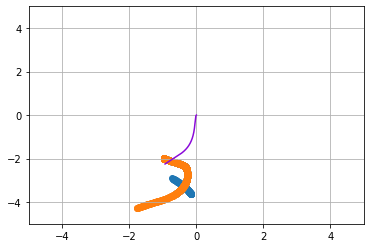

In [123]:
plt.figure()
plt.grid()
plt.xlim(-5,5)
plt.ylim(-5,5)

i = 1
z_states_agent = [exp.z_state for exp in buffers.buffers[i]]

zi = np.zeros([len(z_states_agent), 2])
zj1 = np.zeros([len(z_states_agent), 2])
zj2 = np.zeros([len(z_states_agent), 2])

for t, z_sate in enumerate(z_states_agent):
    zi[t,:]  = z_sate[0:2]
    zj1[t,:] = z_sate[2:4] + zi[t,:]
    zj2[t,:] = z_sate[4:6] + zi[t,:]

agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
plt.plot(zi[:,0],zi[:,1], color = agent_color)
plt.scatter(zj1[:,0],zj1[:,1])
plt.scatter(zj2[:,0],zj2[:,1])

plt.show()

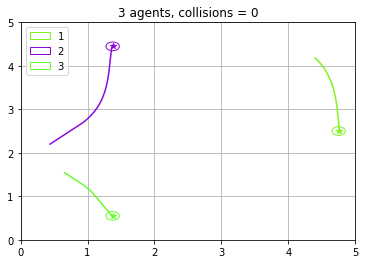

In [119]:
env.plot(trajectory)

In [ ]:
env.animate(trajectory)

### Tests

In [308]:

### Set up parameters ###
n_agents = 4
deltas = np.ones(n_agents)*2
env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 5
plot_last = 2

T = 5 # Simulate for T seconds (default dt = drone_env.dt = 0.05s) t_iter t=100
discount_factor = 0.99
alpha_critic = 10**-2
alpha_actor = 10**-5
M = 50 # Epochs, i.e steps of the SDG for the critic NN
dim_z = env.local_state_space # Dimension of the localized z_state space
dim_a = env.local_action_space # Dimension of the local action space

### 

# Initialize variables
total_collisions_per_episode = []
total_reward_per_episode = []
grad_per_episode = np.zeros([N_Episodes, n_agents])
gi_per_episode = np.zeros_like(grad_per_episode)

times = np.arange(0, T, step=drone_env.dt) + drone_env.dt


agents = SA2CAgents(n_agents=env.n_agents, dim_local_state = dim_z, dim_local_action=dim_a, discount=discount_factor, epochs=M, learning_rate_critic=alpha_critic, learning_rate_actor=alpha_critic)
print("### Running Scalable-Actor-Critic with params: ###")
print(f"Episodes = {N_Episodes}, Time iterations = {len(times)} (T = {T}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}, structure of critic NN = {agents.criticsNN[0].input_size}x{agents.criticsNN[0].L1}x{agents.criticsNN[0].L2}x{agents.criticsNN[0].output_size}")
print(f"Discount = {discount_factor}, lr for NN critical  = {alpha_critic}, lr for actor  = {alpha_actor}, epochs M = {M}")

EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
for episode in EPISODES:

    if episode >= N_Episodes-plot_last:
        # reward_history = np.zeros([len(times), env.n_agents])
        trajectory = [env.state.copy()]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)
    # SIMULATION OVER T
    for t_iter, time in enumerate(times):
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states
        Ni = env.Ni

        # calculate actions based on current state
        # actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)
        actions = agents.forward(z_states, Ni)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, Ni,finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        if episode >= N_Episodes-plot_last:
            # reward_history[t_iter,:] = reward
            trajectory.append(new_state.copy())

    ### END OF EPISODES
    # Train of critic with the data of the episode
    current_grad_norms, current_gi_norms = agents.train(buffers, actor_lr = alpha_actor, return_grads=True)

    # Append episodic variables/logs
    total_reward_per_episode.append(total_episode_reward)
    total_collisions_per_episode.append(total_episode_collisions)
    grad_per_episode[episode,:] = np.array(current_grad_norms)
    gi_per_episode[episode,:] = np.array(current_gi_norms)

    if episode >= N_Episodes-plot_last:
        Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_per_episode, 50)[-1]
    average_collisions = running_average(total_collisions_per_episode, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter+1} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter+1}")

    # Plot current trajectory

    if episode >= N_Episodes-plot_last:
        env.plot(trajectory)

        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_approx[i], label=f"i={i}, approx Q")
            plt.plot(times,Q_simulated[i], "--", label=f"i={i}, simulated Q")
            print(f"Agent {i+1} params = \n{agents.actors[i].parameters}")
        plt.legend()
        plt.show()

agents.save(filename="trained")

plot_rewards(total_reward_per_episode,total_collisions_per_episode, n_ep_running_average=50)
plot_grads(grad_per_episode,gi_per_episode)

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[3.74 3.96 0.   0.   0.1 ]
 [3.74 1.98 0.   0.   0.1 ]
 [1.32 3.74 0.   0.   0.1 ]
 [3.96 1.76 0.   0.   0.1 ]]
safety distance for each agent:
 [2.98 2.98 2.98 2.98]
Deltas disk radius for each agent: 
 [2. 2. 2. 2.]
Obstacles [x, y, r]:
 []

### Running Scalable-Actor-Critic with params: ###
Episodes = 5, Time iterations = 100 (T = 5s, dt = 0.05s)
N of agents = 4, structure of critic NN = 8x200x200x1
Discount = 0.99, lr for NN critical  = 0.01, lr for actor  = 1e-05, epochs M = 50


Episode:   0%|          | 0/5 [00:01<?, ?it/s]


TypeError: 'int' object is not iterable

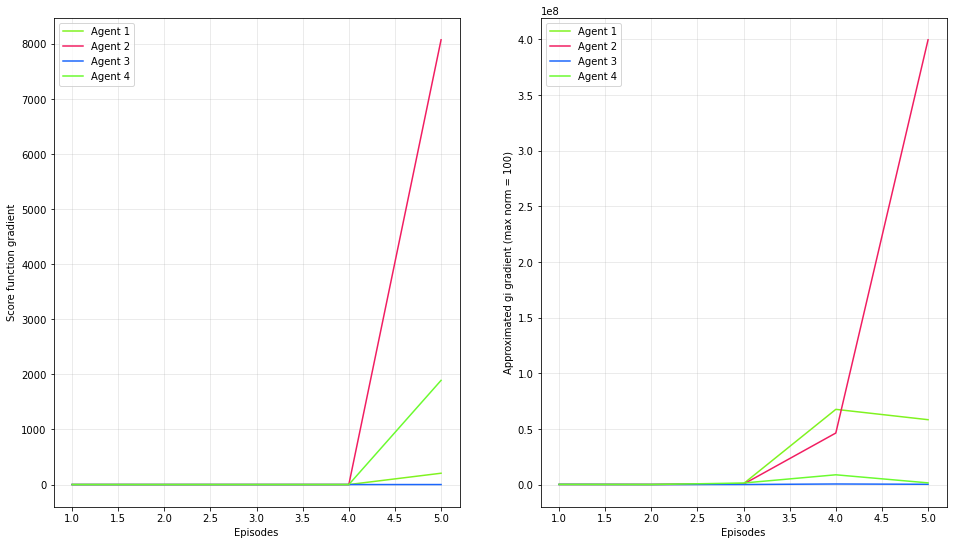

In [307]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
gi_per_episode
grad_per_episode

episode_variable = [e for e in range(1, len(grad_per_episode)+1)]

for i in range(n_agents):
    agent_color = drone_env.num_to_rgb(i,n_agents-1)
    ax[0].plot(episode_variable, grad_per_episode[:,i], label=f"Agent {i+1}", color = agent_color)
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Score function gradient')
ax[0].set_title('Score function gradient')
ax[0].legend()
ax[0].grid(alpha=0.3)

for i in range(n_agents):
    agent_color = drone_env.num_to_rgb(i,n_agents-1)
    ax[1].plot(episode_variable, gi_per_episode[:,i], label=f"Agent {i+1}", color = agent_color)
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Approximated gi gradient (max norm = 100)')
ax[1].set_title('Approximated gi gradient')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

### Numerical gradients

In [112]:
from autograd import numpy as anp
from autograd import grad

In [ ]:
# def my_fun(variable):
#     Ni = [1,2]
#     idx = np.arange(1,int(z_len/dim+1))<=len(Ni)
#     R0 = anp.array([[anp.cos(variable[0]), -anp.sin(variable[0])],[anp.sin(variable[0]),anp.cos(variable[0])]])*idx[0]
#     R1 = anp.array([[anp.cos(variable[1]), -anp.sin(variable[1])],[anp.sin(variable[1]),anp.cos(variable[1])]])*idx[1]
#     R2 = anp.array([[anp.cos(variable[2]), -anp.sin(variable[2])],[anp.sin(variable[2]),anp.cos(variable[2])]])*idx[2]
#     R = anp.concatenate((R0,R1,R2),1)

#     return (-1/2*(a- R @ z).T @ np.linalg.inv(Sigma) @ (a- R @ z))[0,0]

# print(my_fun(theta))

# fun_grad = grad(my_fun)

initial angles = 
 [0. 0. 0.]
t(50): a-Rz = -2.5009202406018622
Final angles = 
 [ 9.23614626e-05 -8.65305668e-02 -8.53332695e-02]
[[ 0.  0.]
 [-0.  0.]]
t(99): a-Rz = -2.5009202406018622


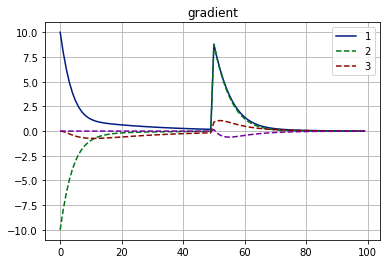

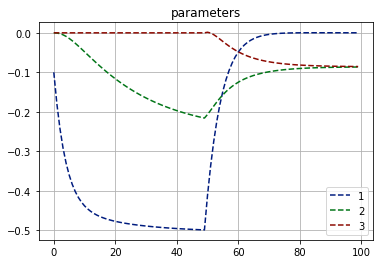

In [214]:
z_dim = 6
dim = 2
z = np.array([[2,0,0,1,0,-1]]).T
a = np.array([[2,0.0]]).T
Ni=[1,2]
idx = np.arange(1,int(z_dim/dim+1))<=len(Ni)
T = 100

policy = NormalPolicy(z_dim,dim, anp.array([[0.2,0],[0,0.2]]))

print("initial angles = \n",policy.parameters)
grad_norms = []
params = np.zeros([T,3])
grads = np.zeros([T,3])

for t in range(T):
    if t == int(T/2):
        # a = np.array([[1,1]]).T
        # z = -np.array([[0.5,2,1,2.5,1,1]]).T
        Ni = [1,2,3]
        print(f"t({t}): a-Rz = {(-1/2*(a- R @ z).T @ np.linalg.inv(policy.Sigma) @ (a- R @ z))[0,0]}")

    log_grad = policy.compute_grad(z.flatten(),a.flatten(),Ni)
    grad_norms.append(np.linalg.norm(log_grad))
    # print(f"params = {policy.parameters}, grad = {log_grad}")
    policy.parameters += log_grad*10**-2
    params[t,:] = policy.parameters
    grads[t,:] = policy.grad

print("Final angles = \n",policy.parameters)

variable = params[-1,:]
R0 = anp.array([[anp.cos(variable[0]), -anp.sin(variable[0])],[anp.sin(variable[0]),anp.cos(variable[0])]])*idx[0]
R1 = anp.array([[anp.cos(variable[1]), -anp.sin(variable[1])],[anp.sin(variable[1]),anp.cos(variable[1])]])*idx[1]
R2 = anp.array([[anp.cos(variable[2]), -anp.sin(variable[2])],[anp.sin(variable[2]),anp.cos(variable[2])]])*idx[2]
print(R2)
R = anp.concatenate((R0,R1,R2),1)

print(f"t({t}): a-Rz = {(-1/2*(a- R @ z).T @ np.linalg.inv(policy.Sigma) @ (a- R @ z))[0,0]}")

plt.figure()
# plt.plot(range(T),grad_norms)
plt.plot(range(T),grad_norms,range(T),grads,"--")
plt.legend(["1","2","3"])
plt.grid()
plt.title("gradient")
plt.show()

plt.figure()
style = ["--","--","--"]
for i in range(3):
    plt.plot(range(T),params[:,i],style[i],)
plt.legend(["1","2","3"])
plt.grid()
plt.title("parameters")
plt.show()
    


In [6]:
np.pi/1.5

2.0943951023931953

## Frame plot test

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[3.3  1.76 0.   0.   0.1 ]
 [1.76 4.62 0.   0.   0.1 ]
 [0.66 1.32 0.   0.   0.1 ]
 [4.4  1.32 0.   0.   0.1 ]
 [2.64 1.32 0.   0.   0.1 ]]
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1. 1. 1. 1. 1.]
Obstacles [x, y, r]:
 []

### Running Scalable-Actor-Critic with params: ###
Episodes = 1, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.01, lr for actor  = 0.0001, epochs M = 2


Episode 0 - Reward/Collisions/Steps: -15.2/0/163 - Average: 0.0/0.00/163:   0%|          | 0/1 [00:01<?, ?it/s]

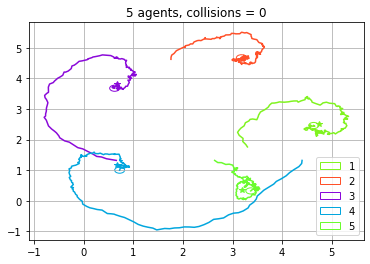

Agent 0 params = [-1.99784584 -2.0002238  -2.00103492]
Agent 1 params = [-1.99986205 -2.         -2.        ]
Agent 2 params = [-2.00447045 -2.         -2.        ]
Agent 3 params = [-1.9901917  -2.00194866 -2.        ]
Agent 4 params = [-2.00123284 -1.99876388 -1.99994488]


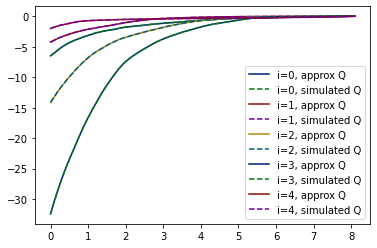

Episode 0 - Reward/Collisions/Steps: -15.2/0/163 - Average: 0.0/0.00/163: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


In [4]:
### Set up parameters ###
n_agents = 5
deltas = np.ones(n_agents)*1
# deltas = None
env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 1  
plot_last = 1

# T = 8 # Simulate for T seconds (default dt = drone_env.dt = 0.05s) t_iter t=80
discount_factor = 0.99
alpha_critic = 10**-2
alpha_actor = 10**-4
M = 2 # Epochs, i.e steps of the SDG for the critic NN
dim_z = env.local_state_space # Dimension of the localized z_state space
dim_a = env.local_action_space # Dimension of the local action space

### 

# Initialize variables
total_collisions_per_episode = []
total_reward_per_episode = []
grad_per_episode = np.zeros([N_Episodes, n_agents])
gi_per_episode = np.zeros_like(grad_per_episode)

# times = np.arange(0, T, step=drone_env.dt) + drone_env.dt


agents = SACAgents(n_agents=env.n_agents, dim_local_state = dim_z, dim_local_action=dim_a, discount=discount_factor, epochs=M, learning_rate_critic=alpha_critic, learning_rate_actor=alpha_critic)
print("### Running Scalable-Actor-Critic with params: ###")
print(f"Episodes = {N_Episodes}, max Time iterations = {drone_env.max_time_steps} (T = {drone_env.max_time_steps * drone_env.dt}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}, structure of critic NN = {agents.criticsNN[0].input_size}x{agents.criticsNN[0].L1}x{agents.criticsNN[0].L2}x{agents.criticsNN[0].output_size}")
print(f"Discount = {discount_factor}, lr for NN critical  = {alpha_critic}, lr for actor  = {alpha_actor}, epochs M = {M}")

EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
for episode in EPISODES:

    if episode >= N_Episodes-plot_last:
        # reward_history = np.zeros([len(times), env.n_agents])
        trajectory = [env.state.copy()]
        z_trajectory = [env.z_states]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)

    # SIMULATION OVER T
    t_iter = 0
    finished = False
    while not finished:
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states
        Ni = env.Ni

        # calculate actions based on current state
        # actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)
        actions = agents.forward(z_states, Ni)
        # actions = agents.forward(z_states, Ni)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, Ni,finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        if episode >= N_Episodes-plot_last:
            # reward_history[t_iter,:] = reward
            trajectory.append(new_state.copy())
            z_trajectory.append(new_z)
        
        t_iter +=1

    ### END OF EPISODES
    # Train of critic with the data of the episode
    current_grad_norms, current_gi_norms = agents.train(buffers, actor_lr = alpha_actor, return_grads=True)

    # Append episodic variables/logs
    total_reward_per_episode.append(total_episode_reward)
    total_collisions_per_episode.append(total_episode_collisions)
    grad_per_episode[episode,:] = np.array(current_grad_norms)
    gi_per_episode[episode,:] = np.array(current_gi_norms)

    if episode >= N_Episodes-plot_last:
        Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_per_episode, 50)[-1]
    average_collisions = running_average(total_collisions_per_episode, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter}")

    # Plot current trajectory

    if episode >= N_Episodes-plot_last:
        env.plot(trajectory)
        times = np.arange(0, t_iter)*drone_env.dt
        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_approx[i], label=f"i={i}, approx Q")
            plt.plot(times,Q_simulated[i], "--", label=f"i={i}, simulated Q")
            print(f"Agent {i} params = {agents.actors[i].parameters}")
        plt.legend()
        plt.show()

# agents.save(filename="trained")

# plot_rewards(total_reward_per_episode,total_collisions_per_episode, n_ep_running_average=50)
# plt.savefig("images/reward_training.pdf",format='pdf', bbox_inches='tight')
# plot_grads(grad_per_episode,gi_per_episode)

Saving animation...
Animation saved as videos\test.mp4


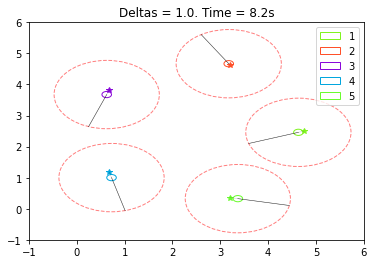

In [5]:
env.animate(trajectory, z_trajectory, deltas, format="mp4")

In [19]:
n_actions = 4
action_norm = 1
action_list = []
for n_action in range(n_actions):
    ax = np.cos(n_action/n_actions * 2*np.pi)*action_norm
    ay = np.sin(n_action/n_actions * 2*np.pi)*action_norm
    action_list.append(np.array([ax,ay]))

print(action_list)
a = action_list[3]
action_list = np.array(action_list)
print(np.where((action_list[:,0] == a[0]) & (action_list[:,1]==a[1]))[0][0])

[array([1., 0.]), array([6.123234e-17, 1.000000e+00]), array([-1.0000000e+00,  1.2246468e-16]), array([-1.8369702e-16, -1.0000000e+00])]
3


1.2246467991473532e-16

In [2]:
actors = torch.load("models\\final\\simple-A2Cactors.pth")

# Delta test $\Delta$

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[1.76 1.1  0.   0.   0.1 ]
 [1.1  3.3  0.   0.   0.1 ]
 [0.22 0.88 0.   0.   0.1 ]
 [3.74 0.   0.   0.   0.1 ]
 [4.62 2.2  0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.01 0.01 0.01 0.01 0.01]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -30.4/0/101 - Average: -82.0/3.00/101. True r=-82.9.: 100%|█████████▉| 1999/2000 [33:04<00:00,  1.42it/s]     

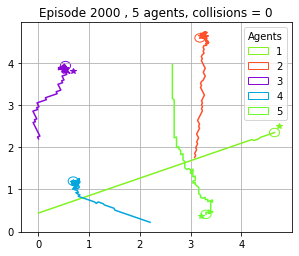

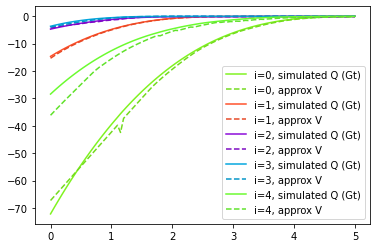

Episode 1999 - Reward/Collisions/Steps: -30.4/0/101 - Average: -82.0/3.00/101. True r=-82.9.: 100%|██████████| 2000/2000 [33:04<00:00,  1.01it/s]


Saved Critic NNs as deltas0.01_softmax16-A2Ccritics.pth
Saved Actors List as deltas0.01_softmax16-A2Cactors.pth


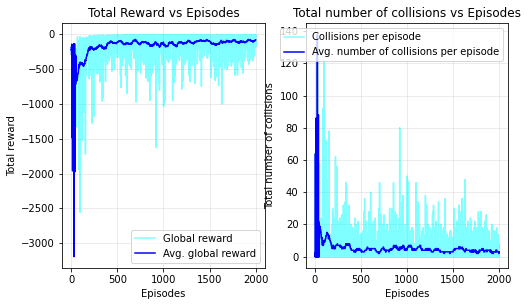

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[1.98 3.74 0.   0.   0.1 ]
 [0.   1.76 0.   0.   0.1 ]
 [2.2  0.44 0.   0.   0.1 ]
 [3.52 0.66 0.   0.   0.1 ]
 [2.42 3.08 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.1 0.1 0.1 0.1 0.1]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -21.9/0/109 - Average: -156.4/6.00/132. True r=-157.5.: 100%|█████████▉| 1999/2000 [30:24<00:00,  1.45it/s]   

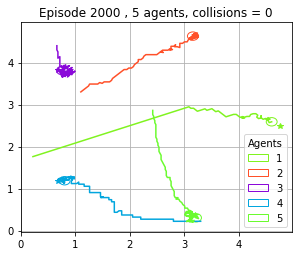

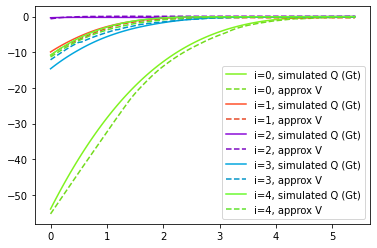

Episode 1999 - Reward/Collisions/Steps: -21.9/0/109 - Average: -156.4/6.00/132. True r=-157.5.: 100%|██████████| 2000/2000 [30:25<00:00,  1.10it/s]


Saved Critic NNs as deltas0.1_softmax16-A2Ccritics.pth
Saved Actors List as deltas0.1_softmax16-A2Cactors.pth


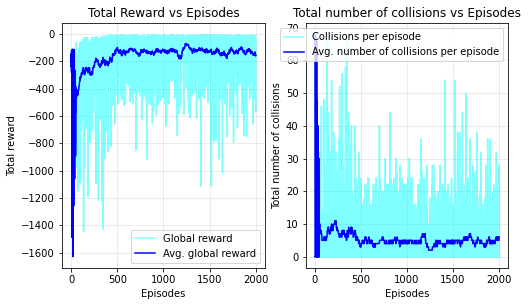

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[2.86 0.44 0.   0.   0.1 ]
 [0.44 2.86 0.   0.   0.1 ]
 [4.4  4.18 0.   0.   0.1 ]
 [1.32 1.32 0.   0.   0.1 ]
 [0.22 0.66 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.2 0.2 0.2 0.2 0.2]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -75.2/2/109 - Average: -71.5/2.00/95. True r=-72.3.: 100%|█████████▉| 1999/2000 [28:12<00:00,  1.59it/s]     

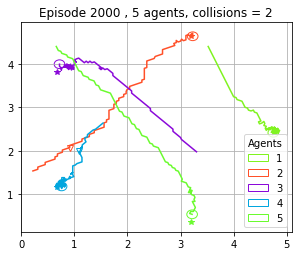

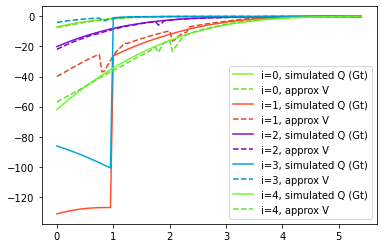

Episode 1999 - Reward/Collisions/Steps: -75.2/2/109 - Average: -71.5/2.00/95. True r=-72.3.: 100%|██████████| 2000/2000 [28:13<00:00,  1.18it/s]


Saved Critic NNs as deltas0.2_softmax16-A2Ccritics.pth
Saved Actors List as deltas0.2_softmax16-A2Cactors.pth


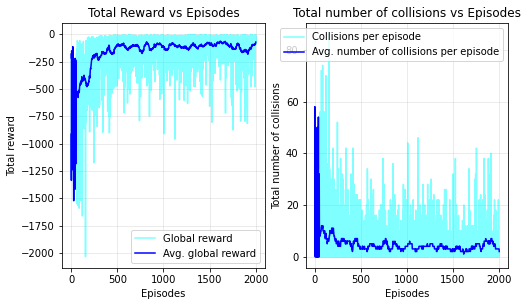

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[0.66 1.32 0.   0.   0.1 ]
 [3.74 0.   0.   0.   0.1 ]
 [3.52 4.62 0.   0.   0.1 ]
 [4.4  3.3  0.   0.   0.1 ]
 [4.18 0.   0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.5 0.5 0.5 0.5 0.5]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -50.9/0/98 - Average: -76.5/2.00/92. True r=-77.3.: 100%|█████████▉| 1999/2000 [29:16<00:00,  1.59it/s]      

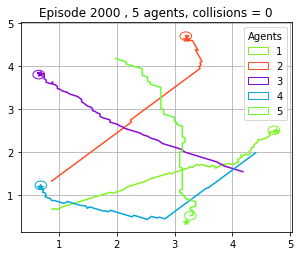

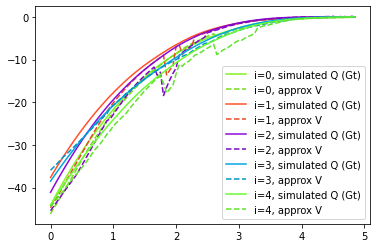

Episode 1999 - Reward/Collisions/Steps: -50.9/0/98 - Average: -76.5/2.00/92. True r=-77.3.: 100%|██████████| 2000/2000 [29:16<00:00,  1.14it/s]


Saved Critic NNs as deltas0.5_softmax16-A2Ccritics.pth
Saved Actors List as deltas0.5_softmax16-A2Cactors.pth


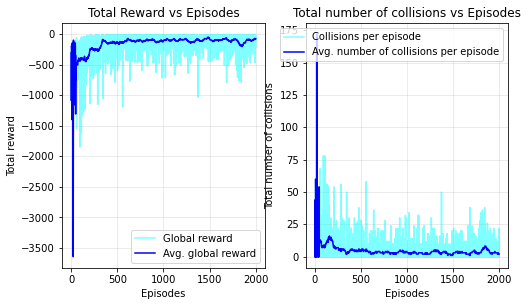

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[4.18 0.66 0.   0.   0.1 ]
 [3.52 4.4  0.   0.   0.1 ]
 [0.88 4.4  0.   0.   0.1 ]
 [1.54 0.   0.   0.   0.1 ]
 [0.66 3.08 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.8 0.8 0.8 0.8 0.8]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -212.7/8/145 - Average: -94.9/3.00/110. True r=-95.6.: 100%|█████████▉| 1999/2000 [4:05:25<00:00,  1.40it/s]       

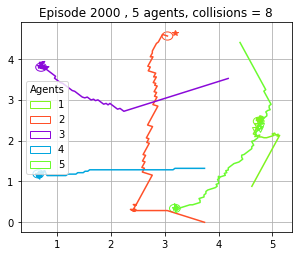

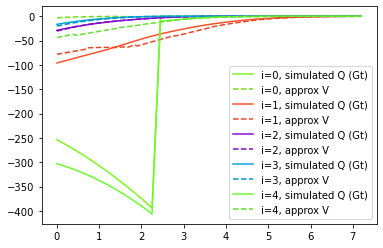

Episode 1999 - Reward/Collisions/Steps: -212.7/8/145 - Average: -94.9/3.00/110. True r=-95.6.: 100%|██████████| 2000/2000 [4:05:25<00:00,  7.36s/it]


Saved Critic NNs as deltas0.8_softmax16-A2Ccritics.pth
Saved Actors List as deltas0.8_softmax16-A2Cactors.pth


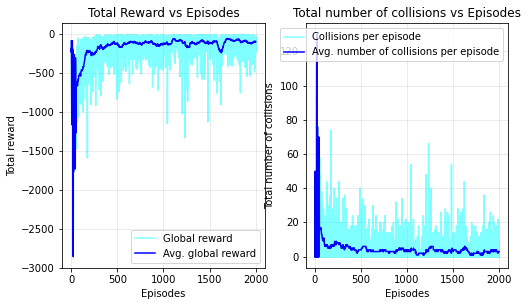

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[2.86 1.76 0.   0.   0.1 ]
 [1.98 0.66 0.   0.   0.1 ]
 [1.76 3.08 0.   0.   0.1 ]
 [2.42 4.62 0.   0.   0.1 ]
 [1.1  0.22 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1. 1. 1. 1. 1.]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -53.7/0/198 - Average: -107.1/3.00/122. True r=-107.6.: 100%|█████████▉| 1999/2000 [32:33<00:00,  1.05it/s]   

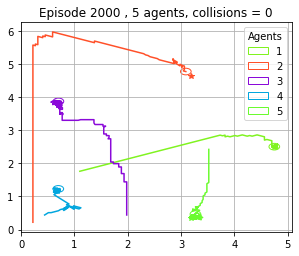

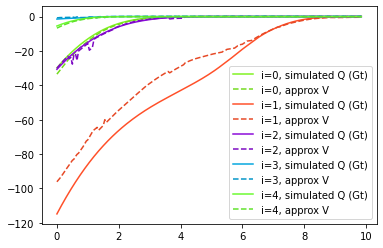

Episode 1999 - Reward/Collisions/Steps: -53.7/0/198 - Average: -107.1/3.00/122. True r=-107.6.: 100%|██████████| 2000/2000 [32:33<00:00,  1.02it/s]


Saved Critic NNs as deltas1_softmax16-A2Ccritics.pth
Saved Actors List as deltas1_softmax16-A2Cactors.pth


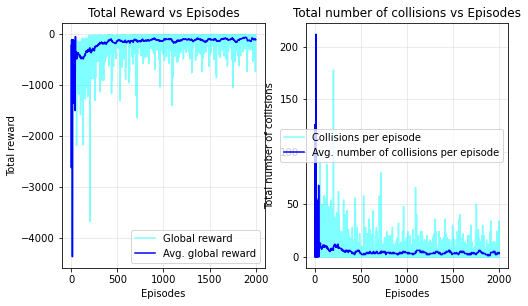

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[3.3  4.4  0.   0.   0.1 ]
 [2.86 1.76 0.   0.   0.1 ]
 [0.44 0.44 0.   0.   0.1 ]
 [0.   0.44 0.   0.   0.1 ]
 [2.42 0.22 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1.5 1.5 1.5 1.5 1.5]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -41.3/0/200 - Average: -81.1/2.00/131. True r=-81.4.: 100%|█████████▉| 1999/2000 [36:44<00:00,  1.02it/s]     

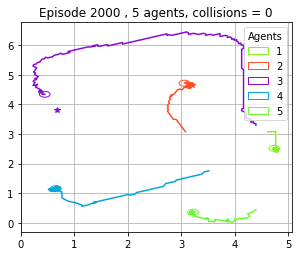

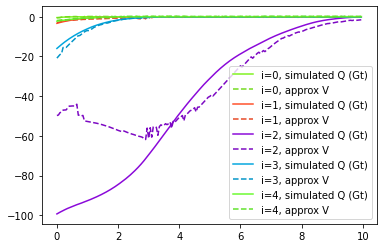

Episode 1999 - Reward/Collisions/Steps: -41.3/0/200 - Average: -81.1/2.00/131. True r=-81.4.: 100%|██████████| 2000/2000 [36:45<00:00,  1.10s/it]


Saved Critic NNs as deltas1.5_softmax16-A2Ccritics.pth
Saved Actors List as deltas1.5_softmax16-A2Cactors.pth


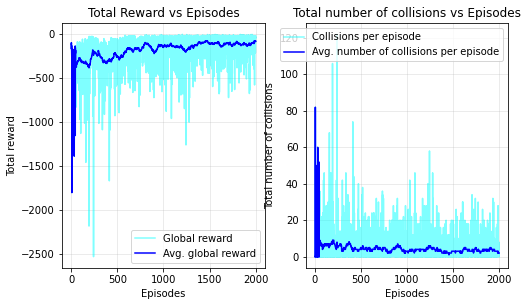

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[3.74 2.2  0.   0.   0.1 ]
 [3.96 1.76 0.   0.   0.1 ]
 [2.86 1.76 0.   0.   0.1 ]
 [2.64 1.1  0.   0.   0.1 ]
 [3.74 0.   0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [2. 2. 2. 2. 2.]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -350.5/14/200 - Average: -165.4/4.00/196. True r=-165.5.: 100%|█████████▉| 1999/2000 [59:26<00:01,  1.25s/it]    

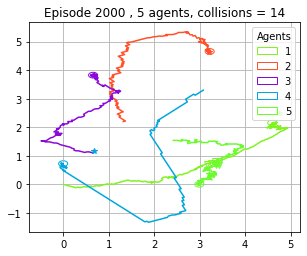

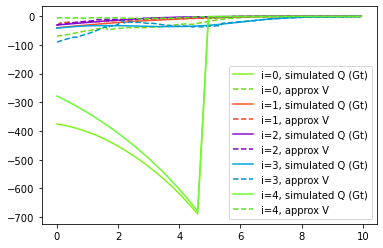

Episode 1999 - Reward/Collisions/Steps: -350.5/14/200 - Average: -165.4/4.00/196. True r=-165.5.: 100%|██████████| 2000/2000 [59:26<00:00,  1.78s/it]


Saved Critic NNs as deltas2_softmax16-A2Ccritics.pth
Saved Actors List as deltas2_softmax16-A2Cactors.pth


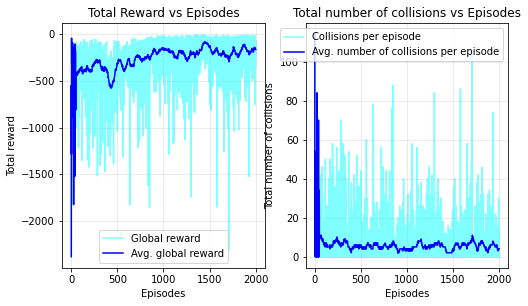

Some deltas are greater than the final minimum distance between end positions. Using minimum distance between end positions for those cases instead. deltas = [2.44 2.44 2.44 2.44 2.44]
Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[2.2  3.3  0.   0.   0.1 ]
 [0.88 2.64 0.   0.   0.1 ]
 [2.64 1.98 0.   0.   0.1 ]
 [1.98 3.96 0.   0.   0.1 ]
 [3.96 1.1  0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [2.44 2.44 2.44 2.44 2.44]
Collision cost weight (per unit of time) = 0.2 

### Running <class 'SAC_agents.SA2CAgents'>, actor: <class 'utils.DiscreteSoftmaxNN'> with params: ###
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.001, lr for actor  = 0.001, epochs M = 10


Episode 1999 - Reward/Collisions/Steps: -359.4/0/200 - Average: -664.7/4.00/200. True r=-664.7.: 100%|█████████▉| 1999/2000 [45:01<00:01,  1.22s/it]    

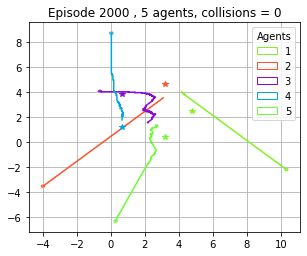

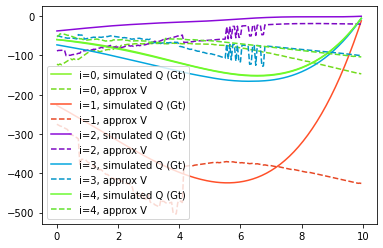

Episode 1999 - Reward/Collisions/Steps: -359.4/0/200 - Average: -664.7/4.00/200. True r=-664.7.: 100%|██████████| 2000/2000 [45:01<00:00,  1.35s/it]


Saved Critic NNs as deltas2.5_softmax16-A2Ccritics.pth
Saved Actors List as deltas2.5_softmax16-A2Cactors.pth


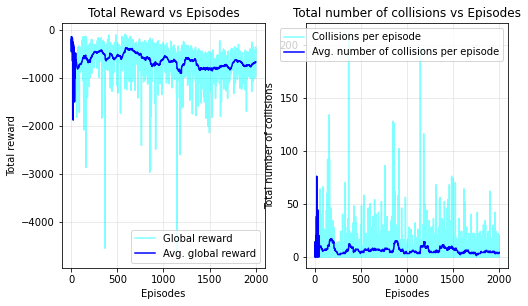

In [2]:
### Set up parameters ###
n_agents = 5
deltas_list = [0.01,0.1,0.2,0.5,0.8,1,1.5,2,2.5]

reward_vs_deltas = []
collisions_vs_deltas = []

for delt in deltas_list:

    if delt is None:
        deltas = None
    else:
        deltas = np.ones(n_agents)*delt
    # deltas = None
    env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
    env.collision_weight = 0.2 # old 0.2
    print(env)
    # env.show()

    N_Episodes = 2000
    # episodes_to_plot = [0]
    episodes_to_plot = [2000]
    save_name = "softmax16_deltas"

    # T = 8 # Simulate for T seconds (default dt = drone_env.dt = 0.05s) t_iter t=80
    discount_factor = 0.99
    alpha_critic = 10**-3
    alpha_actor = 10**-3
    M = 10 # Epochs, i.e steps of the SDG for the actor-critic NN in PPO variant
    dim_z = env.local_state_space # Dimension of the localized z_state space
    dim_a = env.local_action_space # Dimension of the local action space

    ### 

    # Initialize variables
    total_collisions_per_episode = []
    total_reward_per_episode = []
    total_true_reward_per_episode =[]
    total_t = []
    grad_per_episode = np.zeros([N_Episodes, n_agents])
    gi_per_episode = np.zeros_like(grad_per_episode)

    # times = np.arange(0, T, step=drone_env.dt) + drone_env.dt


    agents = SA2CAgents(n_agents=env.n_agents, dim_local_state = dim_z, dim_local_action=dim_a, discount=discount_factor, epochs=M, learning_rate_critic=alpha_critic, learning_rate_actor=alpha_critic)
    print(f"### Running {type(agents)}, actor: {type(agents.actors[0])} with params: ###")
    print(f"Episodes = {N_Episodes}, max Time iterations = {drone_env.max_time_steps} (T = {drone_env.max_time_steps * drone_env.dt}s, dt = {drone_env.dt}s)")
    print(f"N of agents = {env.n_agents}, structure of critic NN = {agents.criticsNN[0].input_size}x{agents.criticsNN[0].L1}x{agents.criticsNN[0].L2}x{agents.criticsNN[0].output_size}")
    print(f"Discount = {discount_factor}, lr for NN critical  = {alpha_critic}, lr for actor  = {alpha_actor}, epochs M = {M}")

    EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
    for episode in EPISODES:

        if episode+1 in episodes_to_plot:
            # reward_history = np.zeros([len(times), env.n_agents])
            trajectory = [env.state.copy()]
            z_trajectory = [env.z_states]
        total_episode_reward = 0
        total_true_episode_reward = 0
        total_episode_collisions = 0
        # env.show()

        buffers = ExperienceBuffers(env.n_agents)

        # SIMULATION OVER T
        t_iter = 0
        finished = False
        while not finished:
            # Simple gradient controller u_i = -grad_i, assuming Nj = V
            state = env.state
            z_states = env.z_states
            Ni = env.Ni

            # calculate actions based on current state
            # actions = drone_env.gradient_control(state, env)
            # actions = drone_env.proportional_control(state, env)
            actions = agents.forward(z_states, Ni)
            # actions = agents.forward(z_states, Ni)

            # Update environment one time step with the actions
            new_state, new_z, rewards, n_collisions, finished, true_rewards = env.step(actions)
            # EXPERIECE: [z_state, action, reward, next_z, finished]
            buffers.append(z_states, actions, rewards,new_z, Ni,finished)

            total_episode_reward += np.mean(rewards)
            total_true_episode_reward += np.mean(true_rewards)
            total_episode_collisions += n_collisions

            if episode+1 in episodes_to_plot:
                # reward_history[t_iter,:] = reward
                trajectory.append(new_state.copy())
                z_trajectory.append(new_z)
            
            t_iter +=1

        ### END OF EPISODES
        # Train of critic with the data of the episode
        # current_grad_norms, current_gi_norms = agents.train(buffers, actor_lr = alpha_actor, return_grads=True)
        if type(agents.actors[0]) is NormalPolicy:
            agents.train_designed_policy(buffers, actor_lr = alpha_actor, return_grads=False)
        else:
            agents.train_NN(buffers, actor_lr = alpha_actor)

        # Append episodic variables/logs
        total_reward_per_episode.append(total_episode_reward)
        total_true_reward_per_episode.append(total_true_episode_reward)
        total_collisions_per_episode.append(total_episode_collisions)
        total_t.append(t_iter)
        # grad_per_episode[episode,:] = np.array(current_grad_norms)
        # gi_per_episode[episode,:] = np.array(current_gi_norms)

        if episode+1 in episodes_to_plot:
            Q_simulated, V_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

        # print(f"Episode collisions = {total_episode_collisions}")
        # env.animate(trajectory,frame_time=0.1)

        # RESET ENVIRONMENT
        env.reset(renew_obstacles=False)

        # Set progress bar description with information
        average_reward = running_average(total_reward_per_episode, 50)[-1]
        average_true_reward = running_average(total_true_reward_per_episode, 50)[-1]
        average_collisions = running_average(total_collisions_per_episode, 50)[-1]
        average_t = running_average(total_t, 50)[-1]
        EPISODES.set_description(
            f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter} - Average: {average_reward:.1f}/{average_collisions:.2f}/{average_t}. True r={average_true_reward:.1f}.")

        # Plot current trajectory

        if episode+1 in episodes_to_plot:
            env.plot(trajectory, episode)
            # env.animate(trajectory, z_trajectory, deltas, episode, name=f"training-E{episode+1}", format="mp4")
            times = np.arange(0, t_iter)*drone_env.dt
            plt.figure()
            for i in range(env.n_agents):
                agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
                plt.plot(times,Q_simulated[i], label=f"i={i}, simulated Q (Gt)", color = agent_color)
                plt.plot(times,V_approx[i],"--" , label=f"i={i}, approx V", color = tuple(0.9*x for x in agent_color))
                if type(agents.actors[0]) is NormalPolicy:
                    print(f"Agent {i} params = {agents.actors[i].parameters}")
            plt.legend()
            plt.show()

    agents.save(filename=f"deltas{delt}_softmax16")
    plot_rewards(total_reward_per_episode, total_true_reward_per_episode, total_collisions_per_episode, n_ep_running_average=50)
    reward_vs_deltas.append(total_true_reward_per_episode)
    collisions_vs_deltas.append(total_collisions_per_episode)
rewards_collisions_deltas = (reward_vs_deltas, collisions_vs_deltas, deltas_list)
torch.save(rewards_collisions_deltas, "variables_with_delta_change_2")

In [3]:
reward_vs_deltas
collisions_vs_deltas
deltas_list

rewards_collisions_deltas = (reward_vs_deltas, collisions_vs_deltas, deltas_list)

In [4]:
torch.save(rewards_collisions_deltas, "variables_with_delta_change_2")
# rewards_collisions_deltas = torch.load("variables_with_delta_change_1")
# (reward_vs_deltas, collisions_vs_deltas, deltas_list) = rewards_collisions_deltas

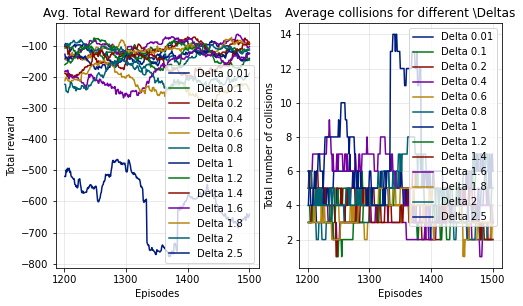

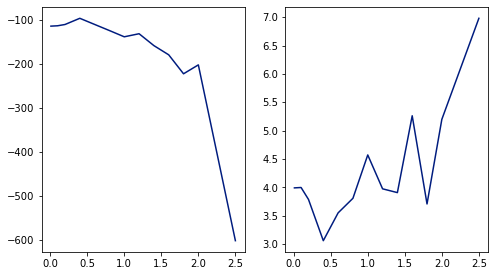

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4.5))
episodes = np.array([i for i in range(1, len(reward_vs_deltas[0])+1)])
interval_to_plot = [1200,1500]

avg_r = []
avg_c = []

for id,delta in enumerate(deltas_list):
    r_to_plot = running_average(reward_vs_deltas[id], 50)
    c_to_plot = running_average(collisions_vs_deltas[id], 50)
    ax[0].plot(episodes[interval_to_plot[0]:interval_to_plot[1]], r_to_plot[interval_to_plot[0]:interval_to_plot[1]], label=f"Delta {delta}")
    ax[1].plot(episodes[interval_to_plot[0]:interval_to_plot[1]], c_to_plot[interval_to_plot[0]:interval_to_plot[1]], label=f"Delta {delta}")
    avg_r.append(np.mean(r_to_plot[interval_to_plot[0]:interval_to_plot[1]]))
    avg_c.append(np.mean(c_to_plot[interval_to_plot[0]:interval_to_plot[1]]))

ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Avg. Total Reward for different \Deltas')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of collisions')
ax[1].set_title('Average collisions for different \Deltas')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(8, 4.5))
ax2[0].plot(np.array(deltas_list), np.array(avg_r))
ax2[1].plot(np.array(deltas_list), np.array(avg_c))

plt.show()

# Collisions histograms

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[0.44 3.74 0.   0.   0.1 ]
 [3.3  3.74 0.   0.   0.1 ]
 [3.3  4.18 0.   0.   0.1 ]
 [1.54 0.44 0.   0.   0.1 ]
 [2.86 1.98 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1. 1. 1. 1. 1.]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.NormalPolicy'>
### Running Trained agent (no learning)
Episodes = 5000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 0.2


Episode 4999 - Reward/Collisions/Steps: -19.4/0/200 - Average: -112.0/4.00/197. True r=-112.2.: 100%|██████████| 5000/5000 [39:43<00:00,  2.10it/s]   


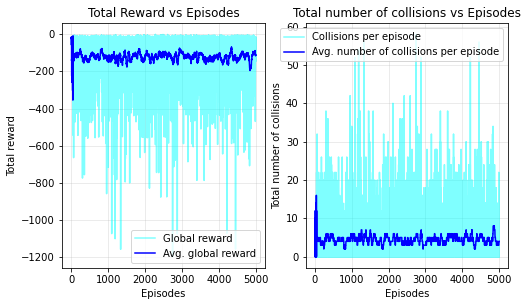

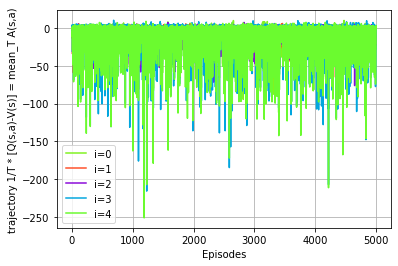

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[1.54 3.3  0.   0.   0.1 ]
 [1.76 2.42 0.   0.   0.1 ]
 [4.4  4.62 0.   0.   0.1 ]
 [3.08 2.42 0.   0.   0.1 ]
 [2.86 4.18 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1. 1. 1. 1. 1.]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 5000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 0.2


Episode 4999 - Reward/Collisions/Steps: -18.4/0/117 - Average: -82.5/2.00/178. True r=-83.2.: 100%|██████████| 5000/5000 [1:39:20<00:00,  1.19s/it]         


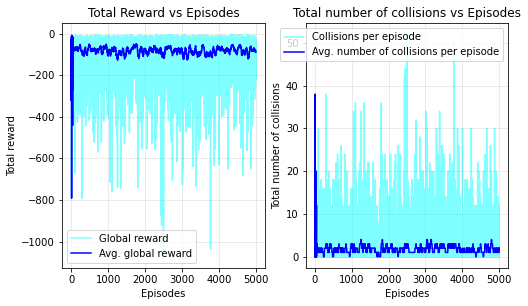

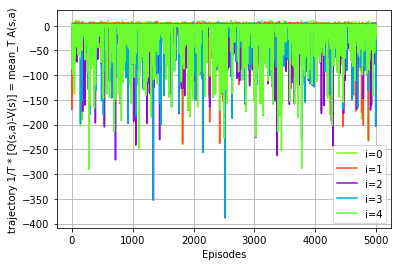

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[2.2  2.64 0.   0.   0.1 ]
 [1.76 3.3  0.   0.   0.1 ]
 [2.42 3.96 0.   0.   0.1 ]
 [0.88 4.18 0.   0.   0.1 ]
 [4.4  0.88 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1. 1. 1. 1. 1.]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.NormalActorNN'>
### Running Trained agent (no learning)
Episodes = 5000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 0.2


Episode 4999 - Reward/Collisions/Steps: -93.0/4/71 - Average: -69.1/2.00/84. True r=-69.4.: 100%|██████████| 5000/5000 [24:37<00:00,  3.38it/s]     


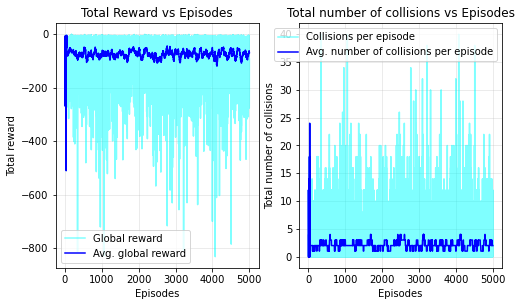

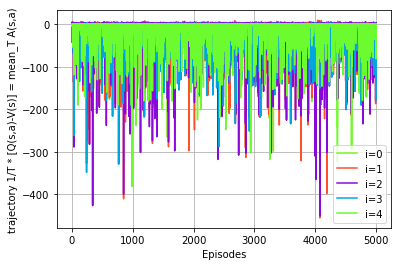

In [6]:
### Set up parameters ###
n_agents = 5
N_Episodes = 5000
episodes_to_plot = [0]
actor_critic_name = ["final\\simple","final\\softmax8_n5","final\\cont_n5"]

reward_vs_policy = []
collisions_vs_policy = []

for policies_name in actor_critic_name:

    deltas = np.ones(n_agents)*1
    env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
    env.collision_weight = 0.2 # old 0.2
    print(env)
    # env.show()

    # Initialize variables
    total_collisions_per_episode = deque()
    total_reward_per_episode = deque()
    total_true_reward_per_episode = deque()
    total_t = deque()
    mean_advantage = np.zeros([env.n_agents, N_Episodes])

    # times = np.arange(0, T, step=drone_env.dt) + drone_env.dt

    agents = TrainedAgent(critics_name=policies_name+"-A2Ccritics.pth", actors_name=policies_name+"-A2Cactors.pth", n_agents=env.n_agents)
    print("### Running Trained agent (no learning)")
    print(f"Episodes = {N_Episodes}, max Time iterations = {drone_env.max_time_steps} (T = {drone_env.max_time_steps * drone_env.dt}s, dt = {drone_env.dt}s)")
    print(f"N of agents = {env.n_agents}, collision weight b = {env.collision_weight}")

    EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
    for episode in EPISODES:

        if episode+1 in episodes_to_plot:
            # reward_history = np.zeros([len(times), env.n_agents])
            trajectory = [env.state.copy()]
            z_trajectory = [env.z_states]    
        total_episode_reward = 0
        total_true_episode_reward = 0
        total_episode_collisions = 0
        # env.show()

        buffers = ExperienceBuffers(env.n_agents)

        # SIMULATION OVER T
        t_iter = 0
        finished = False
        while not finished:

            state = env.state
            z_states = env.z_states
            Ni = env.Ni

            # calculate actions based on current state
            # actions = drone_env.gradient_control(state, env)
            # actions = drone_env.proportional_control(state, env)
            actions = agents.forward(z_states, Ni)

            # Update environment one time step with the actions
            new_state, new_z, rewards, n_collisions, finished, true_rewards = env.step(actions)
            # EXPERIECE: [z_state, action, reward, next_z, finished]
            buffers.append(z_states, actions, rewards, new_z, Ni, finished)

            total_episode_reward += np.mean(rewards)
            total_true_episode_reward += np.mean(true_rewards)
            total_episode_collisions += n_collisions

            if episode+1 in episodes_to_plot:
                # reward_history[t_iter,:] = reward
                trajectory.append(new_state.copy())
                z_trajectory.append(new_z)

            t_iter +=1

        # END OF EPISODE
        # Append episode reward
        total_reward_per_episode.append(total_episode_reward)
        total_true_reward_per_episode.append(total_true_episode_reward)
        total_collisions_per_episode.append(total_episode_collisions)
        total_t.append(t_iter)

        # Test Critic values
        Q_simulated, V_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)
        advantage = [np.mean(np.power(Q_simulated[i]-V_approx[i],1)) for i in range(env.n_agents)]
        mean_advantage[:,episode] = np.array([advantage])

        # print(f"Episode collisions = {total_episode_collisions}")
        # env.animate(trajectory,frame_time=0.1)

        # RESET ENVIRONMENT
        env.reset(renew_obstacles=False)

        # Set progress bar description with information
        average_reward = running_average(total_reward_per_episode, 50)[-1]
        average_true_reward = running_average(total_true_reward_per_episode, 50)[-1]
        average_collisions = running_average(total_collisions_per_episode, 50)[-1]
        average_t = running_average(total_t, 50)[-1]
        EPISODES.set_description(
            f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter} - Average: {average_reward:.1f}/{average_collisions:.2f}/{average_t}. True r={average_true_reward:.1f}.")

        # Plot current trajectory

        if episode+1 in episodes_to_plot:
            env.plot(trajectory, episode)
            env.animate(trajectory, z_trajectory, deltas, episode, name=f"trained-E{episode+1}", format="mp4")
            times = np.arange(0, t_iter)*drone_env.dt
            plt.figure()
            for i in range(env.n_agents):
                agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
                plt.plot(times,Q_simulated[i], label=f"i={i}, simulated Q (Gt)", color = agent_color)
                plt.plot(times,V_approx[i],"--" , label=f"i={i}, approx V", color = tuple(0.9*x for x in agent_color))
            plt.legend()
            plt.show()

    plot_rewards(total_reward_per_episode, total_true_reward_per_episode, total_collisions_per_episode, n_ep_running_average=50)

    plt.figure()
    for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(range(N_Episodes),mean_advantage[i,:], label=f"i={i}", color = agent_color)
    plt.xlabel("Episodes")
    plt.ylabel("trajectory 1/T * [Q(s,a)-V(s)] = mean_T A(s,a)")
    plt.legend()
    plt.grid()
    plt.show()

    # plt.figure()
    # plt.gca().set_size_inches(4.5, 3.5)
    # plt.hist(total_collisions_per_episode, range(min(total_collisions_per_episode), max(total_collisions_per_episode) + 1, 1), weights=np.ones(len(total_collisions_per_episode)) / len(total_collisions_per_episode))
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.title("Collision performance")
    # plt.xlabel("Number of collisions")
    # plt.ylabel("Frequency of Simulations")
    # plt.show()


    reward_vs_policy.append(total_true_reward_per_episode)
    collisions_vs_policy.append(total_collisions_per_episode)

rewards_collisions_policies = (reward_vs_policy, collisions_vs_policy, actor_critic_name)

In [3]:
from matplotlib.ticker import PercentFormatter


In [4]:
torch.save(rewards_collisions_policies,"policy_performance_variables_2")

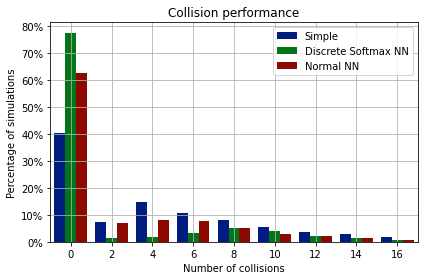

In [47]:
# rewards_collisions_policies = (reward_vs_policy, collisions_vs_policy, actor_critic_name)
names = ["Simple","Discrete Softmax NN","Normal NN"]
w=np.ones(len(collisions_vs_policy[0])) / len(collisions_vs_policy[0])
batches = range(min([min(l) for l in collisions_vs_policy]), max([max(l) for l in collisions_vs_policy])+1,2 )

plt.figure()
# plt.gca().set_size_inches(4.5, 3.5)
counts, bins, bars = plt.hist(collisions_vs_policy, batches , weights=[w,w,w], label=names, align="left")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Collision performance")
plt.xlabel("Number of collisions")
plt.ylabel("Percentage of simulations")
plt.xlim(xmin=-1, xmax = 17)
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig('images\\collisions_hist.pdf')  
plt.show()

In [34]:
for l,policy in enumerate(actor_critic_name):
    print(f"# POLICY: {policy}")
    print(f" 0 coll = {counts[l][0]*100:.2f}%. 2 coll = {counts[l][1]*100:.2f}%. 4 coll = {counts[l][2]*100:.2f}%. 6 coll = {counts[l][3]*100:.2f}%. ")
    print(f" Global reward avg. = {np.mean(reward_vs_policy[l]):.2f}. coll avg. = {np.mean(collisions_vs_policy[l]):.2f}")
    print(f" Global reward std. = {np.std(reward_vs_policy[l]):.2f}. coll std. = {np.std(collisions_vs_policy[l]):.2f}")

# POLICY: final\simple
 0 coll = 40.26%. 2 coll = 7.52%. 4 coll = 14.66%. 6 coll = 10.76%. 
 Global reward avg. = -122.60. coll avg. = 4.90
 Global reward std. = 130.51. coll std. = 6.37
# POLICY: final\softmax8_n5
 0 coll = 77.64%. 2 coll = 1.26%. 4 coll = 1.88%. 6 coll = 3.30%. 
 Global reward avg. = -82.05. coll avg. = 2.25
 Global reward std. = 104.59. coll std. = 5.08
# POLICY: final\cont_n5
 0 coll = 62.82%. 2 coll = 6.98%. 4 coll = 8.12%. 6 coll = 7.84%. 
 Global reward avg. = -75.52. coll avg. = 2.61
 Global reward std. = 94.28. coll std. = 4.57


## $\Delta$ Analysis

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[2.64 1.76 0.   0.   0.1 ]
 [3.08 4.4  0.   0.   0.1 ]
 [0.44 1.54 0.   0.   0.1 ]
 [1.76 2.64 0.   0.   0.1 ]
 [2.64 2.2  0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.01 0.01 0.01 0.01 0.01]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight

Episode 1999 - Reward/Collisions/Steps: -94.1/4/92 - Average: -106.0/3.00/116. True r=-107.0.: 100%|██████████| 2000/2000 [10:26<00:00,  3.19it/s]    


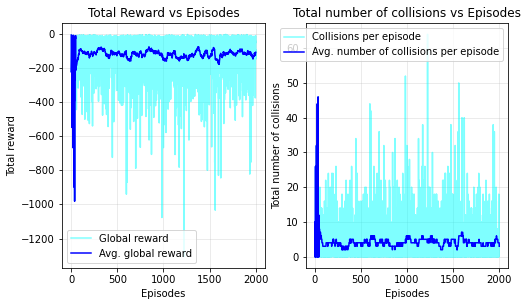

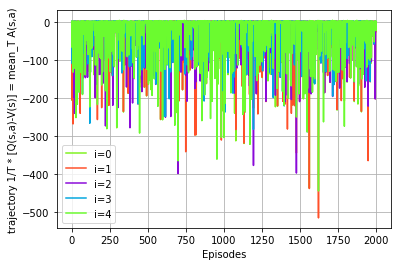

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[0.22 3.08 0.   0.   0.1 ]
 [3.08 0.22 0.   0.   0.1 ]
 [3.3  3.96 0.   0.   0.1 ]
 [1.54 4.18 0.   0.   0.1 ]
 [1.1  1.76 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.1 0.1 0.1 0.1 0.1]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 

Episode 1999 - Reward/Collisions/Steps: -236.7/10/108 - Average: -95.8/3.00/100. True r=-96.8.: 100%|██████████| 2000/2000 [09:10<00:00,  3.63it/s]   


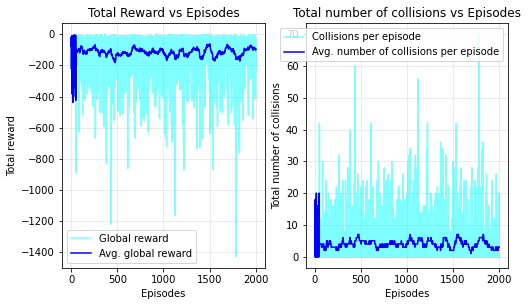

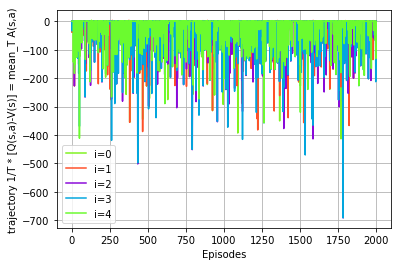

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[3.52 0.22 0.   0.   0.1 ]
 [4.18 1.76 0.   0.   0.1 ]
 [0.88 4.18 0.   0.   0.1 ]
 [2.64 4.4  0.   0.   0.1 ]
 [0.22 2.2  0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.2 0.2 0.2 0.2 0.2]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 

Episode 1999 - Reward/Collisions/Steps: -181.5/8/91 - Average: -127.4/5.00/99. True r=-128.3.: 100%|██████████| 2000/2000 [09:03<00:00,  3.68it/s]   


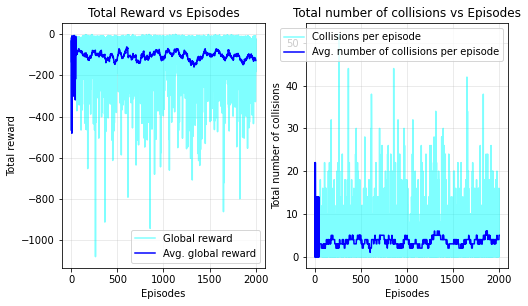

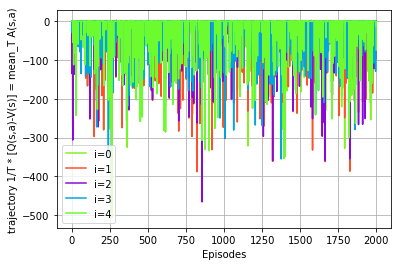

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[1.54 0.88 0.   0.   0.1 ]
 [1.54 3.96 0.   0.   0.1 ]
 [3.96 1.54 0.   0.   0.1 ]
 [3.96 4.4  0.   0.   0.1 ]
 [2.2  1.32 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.5 0.5 0.5 0.5 0.5]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 

Episode 1999 - Reward/Collisions/Steps: -26.6/0/96 - Average: -72.9/2.00/96. True r=-73.6.: 100%|██████████| 2000/2000 [08:37<00:00,  3.87it/s]      


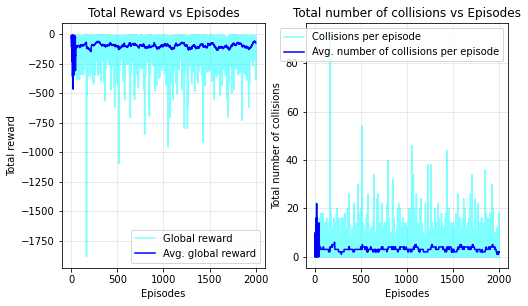

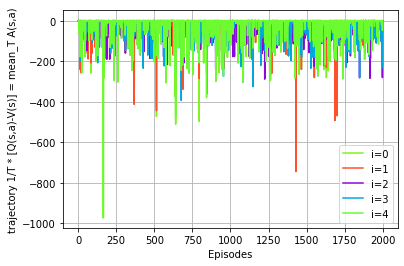

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[1.1  2.2  0.   0.   0.1 ]
 [3.52 3.52 0.   0.   0.1 ]
 [0.44 3.52 0.   0.   0.1 ]
 [1.98 0.88 0.   0.   0.1 ]
 [2.2  2.86 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [0.8 0.8 0.8 0.8 0.8]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 

Episode 1999 - Reward/Collisions/Steps: -172.6/8/86 - Average: -118.8/4.00/112. True r=-119.5.: 100%|██████████| 2000/2000 [10:22<00:00,  3.21it/s]  


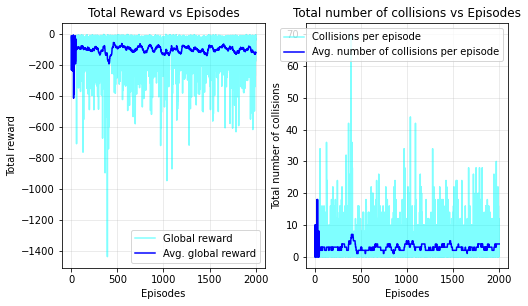

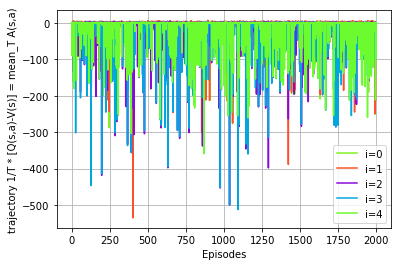

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[0.88 0.66 0.   0.   0.1 ]
 [1.32 0.   0.   0.   0.1 ]
 [2.42 3.08 0.   0.   0.1 ]
 [4.18 2.2  0.   0.   0.1 ]
 [2.64 2.42 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1. 1. 1. 1. 1.]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 0.2


Episode 1999 - Reward/Collisions/Steps: -42.4/0/199 - Average: -121.3/4.00/124. True r=-121.9.: 100%|██████████| 2000/2000 [10:17<00:00,  3.24it/s]  


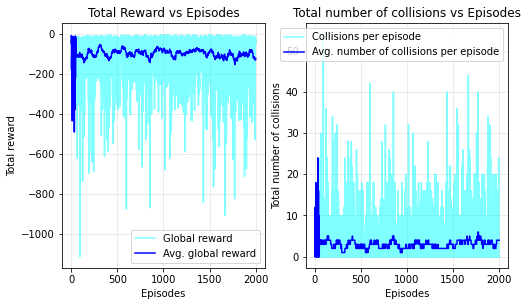

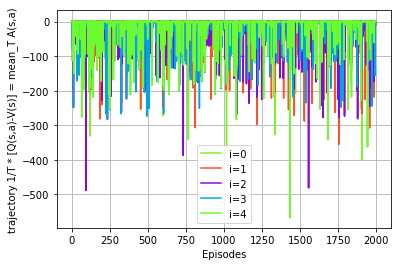

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[4.62 0.88 0.   0.   0.1 ]
 [3.96 0.88 0.   0.   0.1 ]
 [4.18 2.42 0.   0.   0.1 ]
 [1.54 3.08 0.   0.   0.1 ]
 [3.08 0.88 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1.5 1.5 1.5 1.5 1.5]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 

Episode 1999 - Reward/Collisions/Steps: -30.3/0/174 - Average: -102.2/2.00/156. True r=-102.4.: 100%|██████████| 2000/2000 [13:52<00:00,  2.40it/s]   


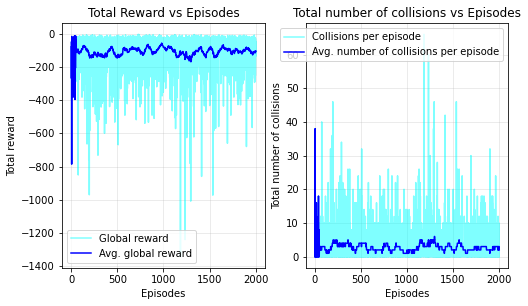

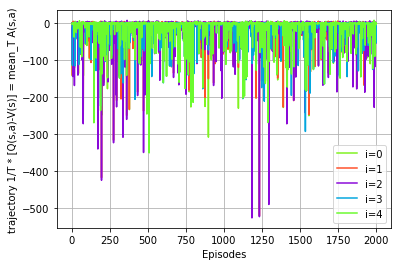

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[2.64 2.64 0.   0.   0.1 ]
 [3.96 0.22 0.   0.   0.1 ]
 [1.32 3.96 0.   0.   0.1 ]
 [1.1  1.1  0.   0.   0.1 ]
 [2.2  1.98 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [2. 2. 2. 2. 2.]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight b = 0.2


Episode 1999 - Reward/Collisions/Steps: -157.1/6/200 - Average: -160.1/5.00/191. True r=-160.2.: 100%|██████████| 2000/2000 [15:52<00:00,  2.10it/s]   


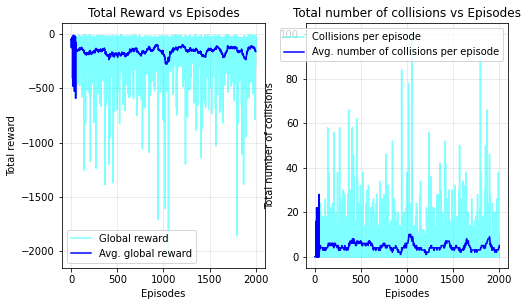

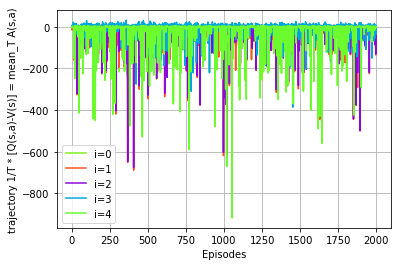

Some deltas are greater than the final minimum distance between end positions. Using minimum distance between end positions for those cases instead. deltas = [2.44 2.44 2.44 2.44 2.44]
Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[0.   2.2  0.   0.   0.1 ]
 [1.98 0.44 0.   0.   0.1 ]
 [0.   3.96 0.   0.   0.1 ]
 [3.08 1.1  0.   0.   0.1 ]
 [3.3  2.86 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [2.44 2.44 2.44 2.44 2.44]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0

Episode 1999 - Reward/Collisions/Steps: -474.0/0/200 - Average: -738.9/5.00/200. True r=-738.9.: 100%|██████████| 2000/2000 [15:34<00:00,  2.14it/s]  


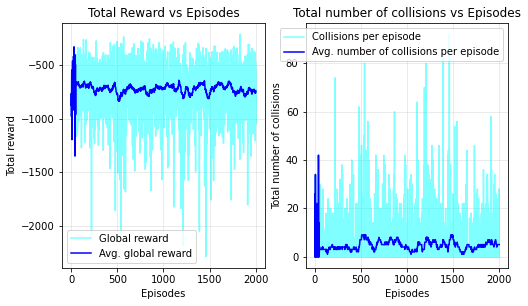

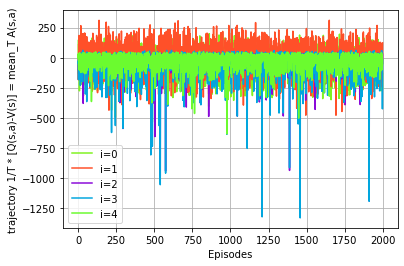

In [53]:
### Set up parameters ###
n_agents = 5
N_Episodes = 2000
episodes_to_plot = [0]
deltas_list = [0.01,0.1,0.2,0.5,0.8,1,1.5,2,2.5]
# actor_critic_name = ["final\\simple","final\\softmax8_n5","final\\cont_n5"]

reward_vs_deltas = []
collisions_vs_deltas = []

for delta in deltas_list:

    deltas = np.ones(n_agents)*delta
    env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
    env.collision_weight = 0.2 # old 0.2
    print(env)
    # env.show()

    # Initialize variables
    total_collisions_per_episode = deque()
    total_reward_per_episode = deque()
    total_true_reward_per_episode = deque()
    total_t = deque()
    mean_advantage = np.zeros([env.n_agents, N_Episodes])

    # times = np.arange(0, T, step=drone_env.dt) + drone_env.dt
    actor_critic_name = f"deltas\\deltas{delta}_softmax16"
    agents = TrainedAgent(critics_name=actor_critic_name+"-A2Ccritics.pth", actors_name=actor_critic_name+"-A2Cactors.pth", n_agents=env.n_agents)
    print("### Running Trained agent (no learning)")
    print(f"Episodes = {N_Episodes}, max Time iterations = {drone_env.max_time_steps} (T = {drone_env.max_time_steps * drone_env.dt}s, dt = {drone_env.dt}s)")
    print(f"N of agents = {env.n_agents}, collision weight b = {env.collision_weight}")

    EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
    for episode in EPISODES:

        if episode+1 in episodes_to_plot:
            # reward_history = np.zeros([len(times), env.n_agents])
            trajectory = [env.state.copy()]
            z_trajectory = [env.z_states]    
        total_episode_reward = 0
        total_true_episode_reward = 0
        total_episode_collisions = 0
        # env.show()

        buffers = ExperienceBuffers(env.n_agents)

        # SIMULATION OVER T
        t_iter = 0
        finished = False
        while not finished:

            state = env.state
            z_states = env.z_states
            Ni = env.Ni

            # calculate actions based on current state
            # actions = drone_env.gradient_control(state, env)
            # actions = drone_env.proportional_control(state, env)
            actions = agents.forward(z_states, Ni)

            # Update environment one time step with the actions
            new_state, new_z, rewards, n_collisions, finished, true_rewards = env.step(actions)
            # EXPERIECE: [z_state, action, reward, next_z, finished]
            buffers.append(z_states, actions, rewards, new_z, Ni, finished)

            total_episode_reward += np.mean(rewards)
            total_true_episode_reward += np.mean(true_rewards)
            total_episode_collisions += n_collisions

            if episode+1 in episodes_to_plot:
                # reward_history[t_iter,:] = reward
                trajectory.append(new_state.copy())
                z_trajectory.append(new_z)

            t_iter +=1

        # END OF EPISODE
        # Append episode reward
        total_reward_per_episode.append(total_episode_reward)
        total_true_reward_per_episode.append(total_true_episode_reward)
        total_collisions_per_episode.append(total_episode_collisions)
        total_t.append(t_iter)

        # Test Critic values
        Q_simulated, V_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)
        advantage = [np.mean(np.power(Q_simulated[i]-V_approx[i],1)) for i in range(env.n_agents)]
        mean_advantage[:,episode] = np.array([advantage])

        # print(f"Episode collisions = {total_episode_collisions}")
        # env.animate(trajectory,frame_time=0.1)

        # RESET ENVIRONMENT
        env.reset(renew_obstacles=False)

        # Set progress bar description with information
        average_reward = running_average(total_reward_per_episode, 50)[-1]
        average_true_reward = running_average(total_true_reward_per_episode, 50)[-1]
        average_collisions = running_average(total_collisions_per_episode, 50)[-1]
        average_t = running_average(total_t, 50)[-1]
        EPISODES.set_description(
            f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter} - Average: {average_reward:.1f}/{average_collisions:.2f}/{average_t}. True r={average_true_reward:.1f}.")

        # Plot current trajectory

        if episode+1 in episodes_to_plot:
            env.plot(trajectory, episode)
            env.animate(trajectory, z_trajectory, deltas, episode, name=f"trained-E{episode+1}", format="mp4")
            times = np.arange(0, t_iter)*drone_env.dt
            plt.figure()
            for i in range(env.n_agents):
                agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
                plt.plot(times,Q_simulated[i], label=f"i={i}, simulated Q (Gt)", color = agent_color)
                plt.plot(times,V_approx[i],"--" , label=f"i={i}, approx V", color = tuple(0.9*x for x in agent_color))
            plt.legend()
            plt.show()

    plot_rewards(total_reward_per_episode, total_true_reward_per_episode, total_collisions_per_episode, n_ep_running_average=50)

    plt.figure()
    for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(range(N_Episodes),mean_advantage[i,:], label=f"i={i}", color = agent_color)
    plt.xlabel("Episodes")
    plt.ylabel("trajectory 1/T * [Q(s,a)-V(s)] = mean_T A(s,a)")
    plt.legend()
    plt.grid()
    plt.show()

    # plt.figure()
    # plt.gca().set_size_inches(4.5, 3.5)
    # plt.hist(total_collisions_per_episode, range(min(total_collisions_per_episode), max(total_collisions_per_episode) + 1, 1), weights=np.ones(len(total_collisions_per_episode)) / len(total_collisions_per_episode))
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.title("Collision performance")
    # plt.xlabel("Number of collisions")
    # plt.ylabel("Frequency of Simulations")
    # plt.show()


    reward_vs_deltas.append(total_true_reward_per_episode)
    collisions_vs_deltas.append(total_collisions_per_episode)

rewards_collisions_deltas = (reward_vs_deltas, collisions_vs_deltas, deltas_list)
torch.save(rewards_collisions_deltas, "variables_with_delta_change_3")


In [93]:
rewards_collisions_deltas = torch.load("variables_with_delta_change_4")
(reward_vs_deltas, collisions_vs_deltas, deltas_list) = rewards_collisions_deltas

In [94]:
for l,delta in enumerate(deltas_list):
    print(f"# Delta: {delta}")
    # print(f" 0 coll = {counts[l][0]*100:.2f}%. 2 coll = {counts[l][1]*100:.2f}%. 4 coll = {counts[l][2]*100:.2f}%. 6 coll = {counts[l][3]*100:.2f}%. ")
    print(f" Global reward avg. = {np.mean(reward_vs_deltas[l]):.2f}. coll avg. = {np.mean(collisions_vs_deltas[l]):.2f}")
    print(f" Global reward std. = {np.std(reward_vs_deltas[l]):.2f}. coll std. = {np.std(collisions_vs_deltas[l]):.2f}")

# Delta: 0.01
 Global reward avg. = -118.78. coll avg. = 4.59
 Global reward std. = 144.84. coll std. = 7.09
# Delta: 0.1
 Global reward avg. = -114.44. coll avg. = 4.47
 Global reward std. = 147.59. coll std. = 7.24
# Delta: 0.2
 Global reward avg. = -105.99. coll avg. = 4.05
 Global reward std. = 137.75. coll std. = 6.74
# Delta: 0.5
 Global reward avg. = -98.36. coll avg. = 3.63
 Global reward std. = 131.96. coll std. = 6.47
# Delta: 0.8
 Global reward avg. = -100.21. coll avg. = 3.39
 Global reward std. = 129.69. coll std. = 6.29
# Delta: 1
 Global reward avg. = -97.86. coll avg. = 3.45
 Global reward std. = 130.07. coll std. = 6.38
# Delta: 1.5
 Global reward avg. = -105.56. coll avg. = 3.21
 Global reward std. = 129.51. coll std. = 6.26
# Delta: 2
 Global reward avg. = -159.13. coll avg. = 5.03
 Global reward std. = 196.44. coll std. = 9.62
# Delta: 2.43
 Global reward avg. = -176.67. coll avg. = 4.71
 Global reward std. = 188.63. coll std. = 9.08


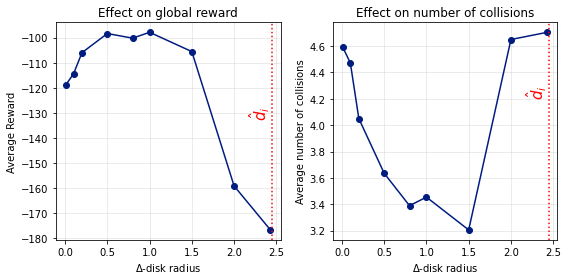

In [131]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

avg_r = [np.mean(r) for r in reward_vs_deltas]
std_r = [np.std(r) for r in reward_vs_deltas]
avg_c = [np.mean(c) for c in collisions_vs_deltas]
std_c = [np.std(c) for c in collisions_vs_deltas]

avg_c[-2]=4.65

ax[0].plot(deltas_list,avg_r, '-o')
ax[1].plot(deltas_list,avg_c, '-o')
# ax[0].errorbar(deltas_list, avg_r, yerr=std_r, fmt='-o')
# ax[1].errorbar(deltas_list, avg_c, yerr=std_c, fmt='-o')

ax[0].set_xlabel('$\Delta$-disk radius')
ax[0].set_ylabel('Average Reward')
ax[0].set_title('Effect on global reward')
ax[0].grid(alpha=0.3)
ax[0].axvline(2.45, color = "red", ymin=0, ymax=1, linestyle = ":")
ax[0].text(2.45,-130,"$\hat{d}_i$", rotation = 90, verticalalignment='center', horizontalalignment='right', color = "red", fontsize = 15)

ax[1].set_xlabel('$\Delta$-disk radius')
ax[1].set_ylabel('Average number of collisions')
ax[1].set_title('Effect on number of collisions')
ax[1].grid(alpha=0.3)
ax[1].axvline(2.45, color = "red", ymin=0, ymax=1, linestyle = ":")
ax[1].text(2.45,4.25,"$\hat{d}_i$", rotation = 90, verticalalignment='center', horizontalalignment='right', color = "red", fontsize = 15)
plt.tight_layout()
plt.savefig("images\\delta_effect.pdf")
plt.show()

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[1.54 1.76 0.   0.   0.1 ]
 [1.54 4.62 0.   0.   0.1 ]
 [2.86 3.96 0.   0.   0.1 ]
 [0.22 1.98 0.   0.   0.1 ]
 [3.52 0.44 0.   0.   0.1 ]]
z_sattes for k_closest = 2: simplify? True
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [2.43 2.43 2.43 2.43 2.43]
Collision cost weight (per unit of time) = 0.2 

Loaded Critic, n_agents = 5, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=6, out_features=200, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Loaded actors, n_agents = 5, discount = 0.99. Type: <class 'utils.DiscreteSoftmaxNN'>
### Running Trained agent (no learning)
Episodes = 2000, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, collision weight

Episode 1999 - Reward/Collisions/Steps: -338.1/14/200 - Average: -250.6/8.00/200. True r=-250.6.: 100%|██████████| 2000/2000 [17:10<00:00,  1.94it/s]  


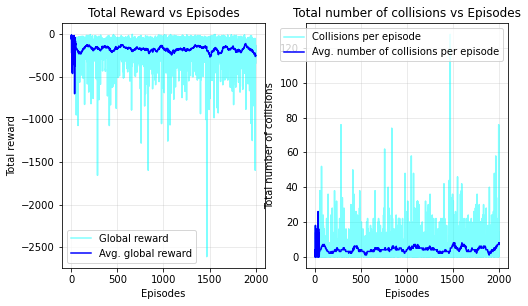

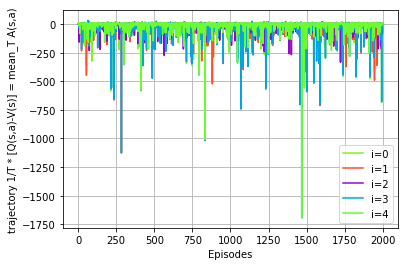

In [71]:
### Set up parameters ###
n_agents = 5
N_Episodes = 2000
episodes_to_plot = [0]
deltas_list = [0.01,0.1,0.2,0.5,0.8,1,1.5,2,2.43]
# actor_critic_name = ["final\\simple","final\\softmax8_n5","final\\cont_n5"]

reward_vs_deltas_last = []
collisions_vs_deltas_last = []

for delta in [2.43]:

    deltas = np.ones(n_agents)*delta
    env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
    env.collision_weight = 0.2 # old 0.2
    print(env)
    # env.show()

    # Initialize variables
    total_collisions_per_episode = deque()
    total_reward_per_episode = deque()
    total_true_reward_per_episode = deque()
    total_t = deque()
    mean_advantage = np.zeros([env.n_agents, N_Episodes])

    # times = np.arange(0, T, step=drone_env.dt) + drone_env.dt
    actor_critic_name = f"deltas\\deltas{delta}_softmax16"
    agents = TrainedAgent(critics_name=actor_critic_name+"-A2Ccritics.pth", actors_name=actor_critic_name+"-A2Cactors.pth", n_agents=env.n_agents)
    print("### Running Trained agent (no learning)")
    print(f"Episodes = {N_Episodes}, max Time iterations = {drone_env.max_time_steps} (T = {drone_env.max_time_steps * drone_env.dt}s, dt = {drone_env.dt}s)")
    print(f"N of agents = {env.n_agents}, collision weight b = {env.collision_weight}")

    EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
    for episode in EPISODES:

        if episode+1 in episodes_to_plot:
            # reward_history = np.zeros([len(times), env.n_agents])
            trajectory = [env.state.copy()]
            z_trajectory = [env.z_states]    
        total_episode_reward = 0
        total_true_episode_reward = 0
        total_episode_collisions = 0
        # env.show()

        buffers = ExperienceBuffers(env.n_agents)

        # SIMULATION OVER T
        t_iter = 0
        finished = False
        while not finished:

            state = env.state
            z_states = env.z_states
            Ni = env.Ni

            # calculate actions based on current state
            # actions = drone_env.gradient_control(state, env)
            # actions = drone_env.proportional_control(state, env)
            actions = agents.forward(z_states, Ni)

            # Update environment one time step with the actions
            new_state, new_z, rewards, n_collisions, finished, true_rewards = env.step(actions)
            # EXPERIECE: [z_state, action, reward, next_z, finished]
            buffers.append(z_states, actions, rewards, new_z, Ni, finished)

            total_episode_reward += np.mean(rewards)
            total_true_episode_reward += np.mean(true_rewards)
            total_episode_collisions += n_collisions

            if episode+1 in episodes_to_plot:
                # reward_history[t_iter,:] = reward
                trajectory.append(new_state.copy())
                z_trajectory.append(new_z)

            t_iter +=1

        # END OF EPISODE
        # Append episode reward
        total_reward_per_episode.append(total_episode_reward)
        total_true_reward_per_episode.append(total_true_episode_reward)
        total_collisions_per_episode.append(total_episode_collisions)
        total_t.append(t_iter)

        # Test Critic values
        Q_simulated, V_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)
        advantage = [np.mean(np.power(Q_simulated[i]-V_approx[i],1)) for i in range(env.n_agents)]
        mean_advantage[:,episode] = np.array([advantage])

        # print(f"Episode collisions = {total_episode_collisions}")
        # env.animate(trajectory,frame_time=0.1)

        # RESET ENVIRONMENT
        env.reset(renew_obstacles=False)

        # Set progress bar description with information
        average_reward = running_average(total_reward_per_episode, 50)[-1]
        average_true_reward = running_average(total_true_reward_per_episode, 50)[-1]
        average_collisions = running_average(total_collisions_per_episode, 50)[-1]
        average_t = running_average(total_t, 50)[-1]
        EPISODES.set_description(
            f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter} - Average: {average_reward:.1f}/{average_collisions:.2f}/{average_t}. True r={average_true_reward:.1f}.")

        # Plot current trajectory

        if episode+1 in episodes_to_plot:
            env.plot(trajectory, episode)
            env.animate(trajectory, z_trajectory, deltas, episode, name=f"trained-E{episode+1}", format="mp4")
            times = np.arange(0, t_iter)*drone_env.dt
            plt.figure()
            for i in range(env.n_agents):
                agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
                plt.plot(times,Q_simulated[i], label=f"i={i}, simulated Q (Gt)", color = agent_color)
                plt.plot(times,V_approx[i],"--" , label=f"i={i}, approx V", color = tuple(0.9*x for x in agent_color))
            plt.legend()
            plt.show()

    plot_rewards(total_reward_per_episode, total_true_reward_per_episode, total_collisions_per_episode, n_ep_running_average=50)

    plt.figure()
    for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(range(N_Episodes),mean_advantage[i,:], label=f"i={i}", color = agent_color)
    plt.xlabel("Episodes")
    plt.ylabel("trajectory 1/T * [Q(s,a)-V(s)] = mean_T A(s,a)")
    plt.legend()
    plt.grid()
    plt.show()

    # plt.figure()
    # plt.gca().set_size_inches(4.5, 3.5)
    # plt.hist(total_collisions_per_episode, range(min(total_collisions_per_episode), max(total_collisions_per_episode) + 1, 1), weights=np.ones(len(total_collisions_per_episode)) / len(total_collisions_per_episode))
    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.title("Collision performance")
    # plt.xlabel("Number of collisions")
    # plt.ylabel("Frequency of Simulations")
    # plt.show()


    reward_vs_deltas_last.append(total_true_reward_per_episode)
    collisions_vs_deltas_last.append(total_collisions_per_episode)

# rewards_collisions_deltas = (reward_vs_deltas, collisions_vs_deltas, deltas_list)
# torch.save(rewards_collisions_deltas, "variables_with_delta_change_3")
